In [1]:
from utils.data_utils import *
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
def concatenate_arrays(row):
    concatenated_array = np.concatenate((row["past_move_12"], row["current_move"]), axis=0)
    return concatenated_array

In [3]:
def inception_block(x, filters):
    conv1x1 = layers.Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)
    conv3x3 = layers.Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv3x3 = layers.Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv3x3)
    conv5x5 = layers.Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv5x5 = layers.Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv5x5)
    maxpool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    maxpool = layers.Conv2D(filters[5], (1, 1), padding='same', activation='relu')(maxpool)
    concatenated = layers.concatenate([conv1x1, conv3x3, conv5x5, maxpool], axis=-1)
    return concatenated

def output_block(x, num_neurons):
    flatten1 = layers.Flatten()(x)
    dense1 = layers.Dense(num_neurons[0], activation = "relu")(flatten1)
    dense2 = layers.Dense(num_neurons[0], activation = "relu")(dense1)
    dense3 = layers.Dense(num_neurons[0], activation = "relu")(dense2)
    output = layers.Dense(1, activation = "sigmoid")(dense3)
    return output

def get_basic_google_le_net(input_shape = (76*2, 8, 8)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((3, 3), padding='same')(x)
    x = inception_block(x, filters=[64, 128, 64, 256, 64, 64])
    x = inception_block(x, filters=[64, 128, 64, 256, 64, 64])
    output1 = output_block(x, num_neurons=[1024, 512, 256])
    x = inception_block(x, filters=[64, 128, 64, 256, 64, 64])
    x = inception_block(x, filters=[64, 128, 64, 256, 64, 64])
    x = inception_block(x, filters=[64, 128, 64, 256, 64, 64])
    output2 = output_block(x, num_neurons=[1024, 512, 256])
    x = inception_block(x, filters=[64, 128, 64, 256, 64, 64])
    x = inception_block(x, filters=[32, 64, 32, 128, 32, 32])
    x = inception_block(x, filters=[16, 32, 16, 64, 16, 16])
    output3 = output_block(x, num_neurons=[1024, 512, 256])
    model = tf.keras.Model(inputs, [output1, output2, output3])
    return model

In [4]:
#Uncomment the below to re-save the data, but you need to clear target directories beforehand
#save_data(txt_file_dir = "D:\\PikeBot\\Small_Preprocessed_Data\\Train", txt_file_name = "train_data.txt", directory_path="D:\\PikeBot\\Small_Data\\Train", file_name="lichess_db_standard_rated_2013-08.pgn.zst", max_num_games=100) #change later when training
#save_data(txt_file_dir = "D:\\PikeBot\\Small_Preprocessed_Data\\Val", txt_file_name = "val_data.txt", directory_path="D:\\PikeBot\\Small_Data\\Val", file_name="lichess_db_standard_rated_2013-01.pgn.zst", max_num_games=20) #change later when training
#save_data(txt_file_dir = "D:\\PikeBot\\Small_Preprocessed_Data\\Test", txt_file_name = "test_data.txt", directory_path="D:\\PikeBot\\Small_Data\\Test", file_name="lichess_db_standard_rated_2013-02.pgn.zst", max_num_games=20) #change later when training

In [5]:
dataframes_train = read_all(text_file_path="D:\\PikeBot\\Small_Preprocessed_Data\\Train\\train_data.txt")
dataframes_val = read_all(text_file_path="D:\\PikeBot\\Small_Preprocessed_Data\\Val\\val_data.txt", num_dataframes=10) #change later when training
dataframes_test = read_all(text_file_path="D:\\PikeBot\\Small_Preprocessed_Data\\Test\\test_data.txt", num_dataframes=10) #change later when training

In [6]:
dataframes_train[0].head()

,human,player,elo,color,event,clock,stockfish_score_depth_1,stockfish_score_depth_2,stockfish_score_depth_3,stockfish_score_depth_4,...,past_move_4,past_move_5,past_move_6,past_move_7,past_move_8,past_move_9,past_move_10,past_move_11,past_move_12,current_move
0,True,JULIJA87,1752,White,Rated Blitz game,NaN,-203,-217,-217,-217,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."
1,True,rikijonson,1681,Black,Rated Blitz game,NaN,-164,-164,-164,-164,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."
2,False,bot,1752,White,Rated Blitz game,NaN,-898,-898,-898,-898,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."
3,True,JULIJA87,1752,White,Rated Blitz game,NaN,-34,-34,-34,-115,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."
4,False,bot,1752,White,Rated Blitz game,NaN,-898,-898,-898,-898,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."


In [7]:
dataframes_val[0].head()

,human,player,elo,color,event,clock,stockfish_score_depth_1,stockfish_score_depth_2,stockfish_score_depth_3,stockfish_score_depth_4,...,past_move_4,past_move_5,past_move_6,past_move_7,past_move_8,past_move_9,past_move_10,past_move_11,past_move_12,current_move
0,True,hostking,1765,White,Rated Classical game,NaN,37,37,37,37,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."
1,True,hostking,1765,White,Rated Classical game,NaN,-25,-25,-25,-25,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1..."
2,True,troepianiz,1752,Black,Rated Classical game,NaN,-19,-19,-19,-19,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1..."
3,True,troepianiz,1752,Black,Rated Classical game,NaN,-195,-195,-195,-195,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."
4,True,troepianiz,1752,Black,Rated Classical game,NaN,-51,-51,-51,-51,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."


In [8]:
dataframes_test[0].head()

,human,player,elo,color,event,clock,stockfish_score_depth_1,stockfish_score_depth_2,stockfish_score_depth_3,stockfish_score_depth_4,...,past_move_4,past_move_5,past_move_6,past_move_7,past_move_8,past_move_9,past_move_10,past_move_11,past_move_12,current_move
0,False,bot,1631,Black,Rated Blitz game,NaN,-207,-219,-219,-219,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."
1,False,bot,1631,Black,Rated Blitz game,NaN,-27,-30,-98,-116,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1..."
2,False,bot,1631,Black,Rated Blitz game,NaN,286,286,319,278,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."
3,True,bijean,1484,White,Rated Blitz game,NaN,205,185,278,281,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."
4,True,bijean,1484,White,Rated Blitz game,NaN,8,8,5,4,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1..."


In [9]:
dataframes_train = pd.concat(dataframes_train, ignore_index=True)
dataframes_val = pd.concat(dataframes_val, ignore_index=True)
dataframes_test = pd.concat(dataframes_test, ignore_index=True)

columns_to_keep = ["past_move_12", "current_move"]
dataframes_train = dataframes_train[dataframes_train['color'] != 'Starting Move']
dataframes_val = dataframes_val[dataframes_val['color'] != 'Starting Move']
dataframes_test = dataframes_test[dataframes_test['color'] != 'Starting Move']

X_train = dataframes_train.drop(columns=dataframes_train.columns.difference(columns_to_keep))
y_train = dataframes_train["human"].astype(int)
X_val = dataframes_val.drop(columns=dataframes_val.columns.difference(columns_to_keep))
y_val = dataframes_val["human"].astype(int)
X_test = dataframes_test.drop(columns=dataframes_test.columns.difference(columns_to_keep))
y_test = dataframes_test["human"].astype(int)

X_train['board'] = X_train.apply(concatenate_arrays, axis=1)
X_val['board'] = X_val.apply(concatenate_arrays, axis=1)
X_test['board'] = X_test.apply(concatenate_arrays, axis=1)

X_train = X_train['board'].values
X_val = X_val['board'].values
X_test = X_test['board'].values

X_train = np.stack(X_train)
X_val = np.stack(X_val)
X_test = np.stack(X_test)

In [10]:
model = get_basic_google_le_net()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 152, 8, 8)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 152, 8, 512)  37376       ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 51, 3, 512)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 51, 3, 128)   65664       ['max_pooling2d[0][0]']          
                                                                                              

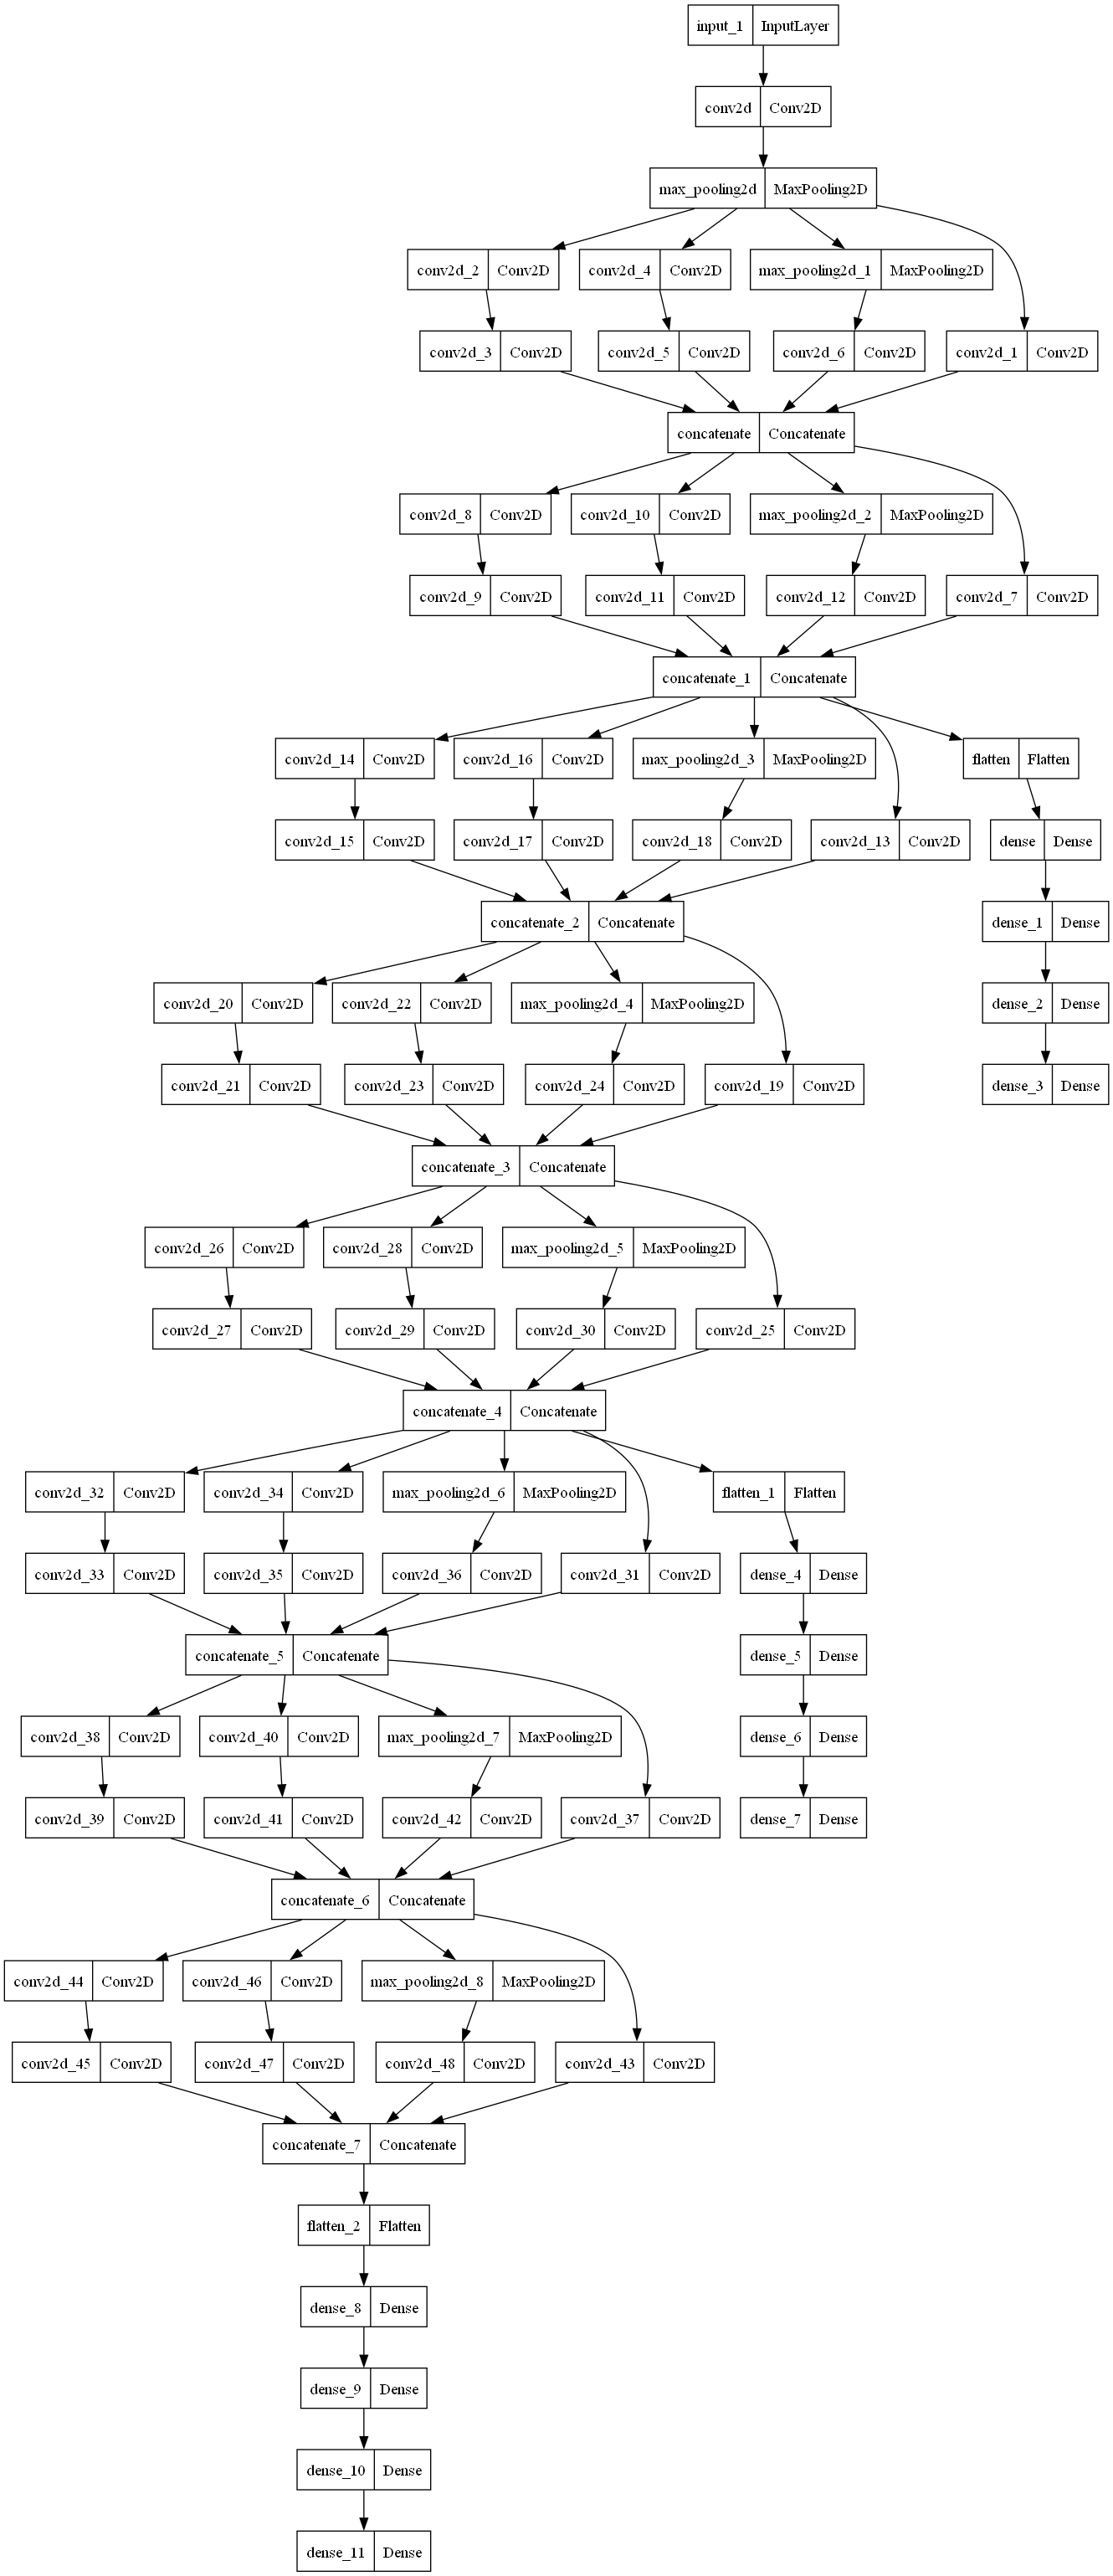

In [11]:
plot_model(model)

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6)

history = model.fit(X_train, y_train, epochs=4, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr]) #Change later for actual training

Epoch 1/4
208/208 [==============================] - 478s 2s/step - loss: 2.1020 - dense_3_loss: 0.7036 - dense_7_loss: 0.7039 - dense_11_loss: 0.6945 - dense_3_accuracy: 0.5026 - dense_3_mae: 0.5000 - dense_7_accuracy: 0.5014 - dense_7_mae: 0.5003 - dense_11_accuracy: 0.5027 - dense_11_mae: 0.5001 - val_loss: 2.0795 - val_dense_3_loss: 0.6932 - val_dense_7_loss: 0.6932 - val_dense_11_loss: 0.6932 - val_dense_3_accuracy: 0.5000 - val_dense_3_mae: 0.5000 - val_dense_7_accuracy: 0.5000 - val_dense_7_mae: 0.5000 - val_dense_11_accuracy: 0.5000 - val_dense_11_mae: 0.5000 - lr: 0.0010
Epoch 2/4
208/208 [==============================] - 464s 2s/step - loss: 2.0796 - dense_3_loss: 0.6932 - dense_7_loss: 0.6932 - dense_11_loss: 0.6932 - dense_3_accuracy: 0.5002 - dense_3_mae: 0.5000 - dense_7_accuracy: 0.4995 - dense_7_mae: 0.5000 - dense_11_accuracy: 0.4995 - dense_11_mae: 0.5000 - val_loss: 2.0795 - val_dense_3_loss: 0.6932 - val_dense_7_loss: 0.6931 - val_dense_11_loss: 0.6932 - val_dense_

In [21]:
results = model.evaluate(X_test, y_test)
loss = results[0]
loss_output1 = results[1]
loss_output2 = results[2]
loss_output3= results[3]
accuracy_output1 = results[4]
mae_output1 = results[5]
accuracy_output2 = results[6]
mae_output2 = results[7]
accuracy_output3 = results[8]
mae_output3 = results[9]
print(f"Test Loss: {loss}")
print(f"Test Loss output1: {loss_output1}")
print(f"Test Loss output2: {loss_output2}")
print(f"Test Loss output3: {loss_output3}")
print(f"Test Accuracy output1: {accuracy_output1}")
print(f"Test Accuracy output2: {accuracy_output2}")
print(f"Test Accuracy output3: {accuracy_output3}")
print(f"Test MAE output1: {mae_output1}")
print(f"Test MAE output2: {mae_output2}")
print(f"Test MAE output3: {mae_output3}")

30/30 [==============================] - 6s 192ms/step - loss: 2.0795 - dense_3_loss: 0.6931 - dense_7_loss: 0.6932 - dense_11_loss: 0.6932 - dense_3_accuracy: 0.5000 - dense_3_mae: 0.5000 - dense_7_accuracy: 0.5000 - dense_7_mae: 0.5000 - dense_11_accuracy: 0.5000 - dense_11_mae: 0.5000
Test Loss: 2.0794520378112793
Test Loss output1: 0.6931483149528503
Test Loss output2: 0.6931501030921936
Test Loss output3: 0.6931535005569458
Test Accuracy output1: 0.5
Test Accuracy output2: 0.5
Test Accuracy output3: 0.5
Test MAE output1: 0.49999991059303284
Test MAE output2: 0.5
Test MAE output3: 0.5000000596046448
